# HW8

1. [Introduction](#Introduction)
2. [Prerequisites and Preprocessing](#Prequisites-and-Preprocessing)
  1. [Permissions and environment variables](#Permissions-and-environment-variables)
  2. [Data ingestion](#Data-ingestion)
  3. [Data inspection](#Data-inspection)
  4. [Data conversion](#Data-conversion)
3. [Training the K-Means model](#Training-the-K-Means-model)
4. [Set up hosting for the model](#Set-up-hosting-for-the-model)
5. [Validate the model for use](#Validate-the-model-for-use)


## Introduction

MNIST database classfication using tensorflow

In [ ]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='sagemaker'

### Data ingestion

Next, we read the dataset from the existing repository into memory, for preprocessing prior to training.  In this case we'll use the MNIST dataset, which contains 70K 28 x 28 pixel images of handwritten digits.  For more details, please see [here](http://yann.lecun.com/exdb/mnist/).

This processing could be done *in situ* by Amazon Athena, Apache Spark in Amazon EMR, Amazon Redshift, etc., assuming the dataset is present in the appropriate location. Then, the next step would be to transfer the data to S3 for use in training. For small datasets, such as this one, reading into memory isn't onerous, though it would be for larger datasets.

In [12]:
%%time
import pickle, gzip, numpy, urllib.request, json

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

CPU times: user 2.23 s, sys: 480 ms, total: 2.71 s
Wall time: 3.64 s


### Data inspection

Once the dataset is imported, it's typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed. You can perform those tasks right here in the notebook. As an example, let's go ahead and look at one of the digits that is part of the dataset.

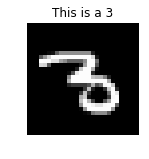

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (2,10)


def show_digit(img, caption='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axis('off')
    subplot.imshow(imgr, cmap='gray')
    plt.title(caption)

show_digit(train_set[0][30], 'This is a {}'.format(train_set[1][30]))

## Setting up tensorflow

In [ ]:
from sagemaker.tensorflow import TensorFlow

mnist_estimator = TensorFlow(entry_point='mnist.py',
                             role=role,
                             training_steps=1000, 
                             evaluation_steps=100,
                             train_instance_count=2,
                             train_instance_type='ml.t2.medium')

mnist_estimator.fit(inputs)

## Deploying trained model

In [ ]:
mnist_predictor = mnist_estimator.deploy(initial_instance_count=1,
                                             instance_type='ml.t2.medium')

## Invoking and Deleting endpoints

In [ ]:
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

for i in range(10):
    data = mnist.test.images[i].tolist()
    tensor_proto = tf.make_tensor_proto(values=np.asarray(data), shape=[1, len(data)], dtype=tf.float32)
    predict_response = mnist_predictor.predict(tensor_proto)
    
    print("========================================")
    label = np.argmax(mnist.test.labels[i])
    print("label is {}".format(label))
    prediction = predict_response['outputs']['classes']['int64Val'][0]
    print("prediction is {}".format(prediction))
    sagemaker.Session().delete_endpoint(mnist_predictor.endpoint)